<a href="https://colab.research.google.com/github/nicolas-chaulet/torch-points3d/blob/modelnettuto/dashboard/ObjectClassificationRSConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Setup anywhere
!pip install torch==1.3.1 pyvista torchvision==0.4.2
!pip install --upgrade jsonschema
!pip install git+git://github.com/nicolas-chaulet/torch-points3d.git@modelnet
!apt-get install -qq xvfb

In [32]:
# Needed for remote rendering 
import os
os.system('export DISPLAY=:99.0 \
export PYVISTA_OFF_SCREEN=true \
export PYVISTA_USE_PANEL=true \
export PYVISTA_PLOT_THEME=document \
# This is needed for Panel - use with cuation!\
export PYVISTA_AUTO_CLOSE=false \
which Xvfb \
Xvfb :99 -screen 0 1024x768x24 > /dev/null 2>&1 & \
sleep 3 \
exec "$@"')

0

In [0]:
import os
import sys
from omegaconf import OmegaConf
import pyvista as pv
import torch

<p align="center">
  <img width="40%" src="https://raw.githubusercontent.com/nicolas-chaulet/torch-points3d/master/docs/logo.png" />
</p>


# Classifiying objects with Relation-Shape CNN
This notebook explains how Torch Points3D can be used to solve an object classification task. We will use [ModelNet](https://modelnet.cs.princeton.edu/) as our dataset and [Relation-Shape CNN](https://github.com/Yochengliu/Relation-Shape-CNN) as our model architecture. The notebook covers the following aspects of Torch Points3D:

1. Create a dataset with a data augmentation pipeline
2. Instantiate a pre configured model
3. Setup the data loaders
4. Run a training


## The dataset
We will use Torch Points3D to download and create the dataset. It automatically downloads a pre sampled version of ModelNet (with 10,000 points per object) and the data will be stored under the `ROOT/data/modelnet` directory. Creating the raw dataset is as simple as:

In [0]:
from torch_points3d.datasets.classification.modelnet import SampledModelNet
import torch_points3d.core.data_transform as T3D
import torch_geometric.transforms as T

dataroot = os.path.join(DIR, "data/modelnet")
pre_transform = T.Compose([T.NormalizeScale(), T3D.GridSampling(0.02)])
dataset = SampledModelNet(dataroot, name='10', train=True, transform=None,
                 pre_transform=pre_transform, pre_filter=None)
dataset[0]

/usr/local/lib/python3.6/dist-packages/torch_geometric/data/dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `data/modelnet/processed/processed` first.
  self.processed_dir))


Processing...


Each sample is a CAD model of an object (bathtub, toilet, bed, etc...), the `pos` attribute contains the coordinates of points sampled on each face of the mesh while `norm` contains the normal vector. You will notice that we have applied two pre transforms to our dataset:

- `NormalizeScale` normalises the scale of each object
- `GridSampling` does a voxel downsizing of each point cloud with a resolution of 0.01 (in normalized scale). This ensures that we don't have really dense areas.

Let's visualise some of those examples before going any further.


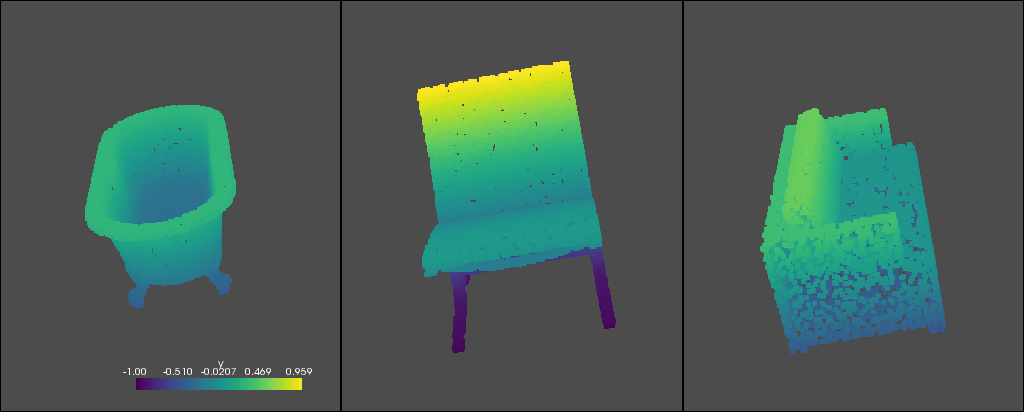

In [35]:
samples = [10,1000,3000]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])

for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset[samples[i]].pos.numpy()
    point_cloud = pv.PolyData(sample)
    point_cloud['y'] = sample[:,1]
    p.add_points(point_cloud)
    p.camera_position = [-1,5, -10]
p.show()

## The model
As mentioned in the introduction we will use Relation-Shape CNN as our backbone architecture for the model classifier. Let's build our model by using Torch Points3D API (you can ignore the error, it comes from a third party library and all works just fine).

In [3]:
from torch_points3d.applications.rsconv import RSConv

ERROR:root:The testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch' 
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [0]:
class RSConvCLassifier(torch.nn.Module):
    def __init__(self):
        super().__init__() 
        self.encoder = RSConv("encoder", input_nc=3,output_nc = 10, num_layers=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)
    
    @property
    def conv_type(self):
        return self.encoder.conv_type
    
    def get_output(self):
        """ This is needed by the tracker to get access to the ouputs of the network"""
        return self.output
    
    def get_labels(self):
        """ Needed by the tracker in order to access ground truth labels"""
        return self.labels
    
    def get_current_losses(self):
        """ Entry point for the tracker to grab the loss """
        return {"loss_class": float(self.loss_class)}
    
    def forward(self, data):
        data_out = self.encoder(data)
        
        # Set variables for the tracker and backward pass
        self.output = self.log_softmax(data_out.x.squeeze())
        self.labels = data.y.squeeze()
        self.loss_class = torch.nn.functional.nll_loss(self.output, self.labels)
    
    def backward(self):
         self.loss_class.backward()    
        

In [15]:
model = RSConvCLassifier()

## The data loaders
In this section, we will first build  a data loader using only PyTorch Geometric methods, and then we will see how one can use our dataset wrapper to assemble a dataset ready for training with its test and train data loader configured.

Let's start with a vanillia data loader. There are two ways to assemble batches depending on the model that is used. In that case we will want dense batches where samples are concatenated along the first dimension, just like for batches of images. It is very important to ensure that each sample has got the same number of points, this can be achieved by applying a `FixedPoints` transform to the dataset. here we will use 2048 points per object.

In [9]:
from torch_points3d.datasets.batch import SimpleBatch
NUM_WORKERS = 4
BATCH_SIZE = 12

transform = T.FixedPoints(2048)
dataset = SampledModelNet(dataroot, name='10', train=True, transform=transform,
                 pre_transform=pre_transform, pre_filter=None)

collate_function = lambda datalist: SimpleBatch.from_data_list(datalist)
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,  
    collate_fn=collate_function
)
next(iter(train_loader))

SimpleBatch(norm=[12, 2048, 3], pos=[12, 2048, 3], y=[12, 1])

If we were using a model that can handle packed data we would not need the `FixedPoints` transform at all and each object could have a different number of points.

In [10]:
from torch_geometric.data import Batch

dataset = SampledModelNet(dataroot, name='10', train=True, transform=None,
                 pre_transform=pre_transform, pre_filter=None)

collate_function = lambda datalist: Batch.from_data_list(datalist)
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,  
    collate_fn=collate_function
)
next(iter(train_loader))

Batch(batch=[114398], norm=[114398, 3], pos=[114398, 3], y=[12])

We also provide a higher level interface that builds the train and test data loaders for you based on which model you use. We use an OmegaConf config to instantiate it (or any object with a similar interface). The config must contain the arguments required by the dataset. We can also include the pre transforms, test transforms and train transforms. In our case, the config will be as follow:

In [0]:
yaml_config = """
task: classification
class: modelnet.ModelNetDataset
name: modelnet
dataroot: {}
number: 10
pre_transforms:
    - transform: NormalizeScale
    - transform: GridSampling
      lparams: [0.02]
train_transforms:
    - transform: FixedPoints
      lparams: [2048]
    - transform: RandomNoise
    - transform: RandomRotate
      params:
        degrees: 180
        axis: 2
    - transform: AddFeatsByKeys
      params:
        feat_names: [norm]
        list_add_to_x: [True]
        delete_feats: [True]
test_transforms:
    - transform: FixedPoints
      lparams: [2048]
    - transform: AddFeatsByKeys
      params:
        feat_names: [norm]
        list_add_to_x: [True]
        delete_feats: [True]
""".format(os.path.join(DIR, "data"))

from omegaconf import OmegaConf
params = OmegaConf.create(yaml_config)

In [12]:
from torch_points3d.datasets.classification.modelnet import ModelNetDataset
dataset = ModelNetDataset(params)
dataset

/usr/local/lib/python3.6/dist-packages/torch_geometric/data/dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `data/modelnet/processed/processed` first.
  self.processed_dir))


Dataset: ModelNetDataset 
pre_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
test_transform = Compose([
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
train_transform = Compose([
    FixedPoints(2048, replace=True),
    RandomNoise(sigma=0.01, clip=0.05),
    RandomRotate((-180, 180), axis=2),
    AddFeatsByKeys(norm=True),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
Size of train_dataset = 3991
Size of test_dataset = 908
Size of val_dataset = 0
Batch size = None

We can see here that the train and test transforms have been set properly. The batch size is still not set since the data loaders have not been instantiaded yet, let's do that now and we will have a dataset ready for training. We can also instantiate the tracker directly from the dataset which reduces potential risks in using the wrong metrics.

In [0]:
dataset.create_dataloaders(
    model, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    precompute_multi_scale=False
)

In [17]:
next(iter(dataset.test_dataloaders[0]))

SimpleBatch(pos=[12, 2048, 3], x=[12, 2048, 3], y=[12, 1])

In [18]:
tracker = dataset.get_tracker(False, False)
tracker

## Training!
We can now start our training loop, we will use the Adam optimizer with a learning rate of 0.01.

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [0]:
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
import time

def train_epoch(device):
    model.to(device)
    model.train()
    tracker.reset("train")
    train_loader = dataset.train_dataloader
    iter_data_time = time.time()
    with Ctq(train_loader) as tq_train_loader:
        for i, data in enumerate(tq_train_loader):
            t_data = time.time() - iter_data_time
            iter_start_time = time.time()
            optimizer.zero_grad()
            data.to(device)
            model.forward(data)
            model.backward()
            optimizer.step()
            
            tracker.track(model)

            tq_train_loader.set_postfix(
                **tracker.get_metrics(),
                data_loading=float(t_data),
                iteration=float(time.time() - iter_start_time),
            )
            iter_data_time = time.time()

In [27]:
train_epoch('cuda')

 44%|████▍     | 148/333 [01:13<01:31,  2.02it/s, data_loading=0.004, iteration=0.472, train_acc=79.56, train_loss_class=0.689]


KeyboardInterrupt: ignored